# Bước 1: Tải thư viện

In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('k_means').getOrCreate()

In [3]:
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyspark.sql.functions import * 
from pyspark.sql.types import *
from pyspark.sql.functions import rand, randn
from pyspark.ml.clustering import KMeans

# Bước 2: Khai thác dữ liệu

1. Tải dữ liệu
2. Xem thông tin số hàng, số cột, tên cột, xem kiểu dữ liệu, dữ liệu trống hay không

In [4]:
df=spark.read.csv('C:/ratings.csv',inferSchema=True,header=True)

In [5]:
print((df.count(),len(df.columns)))

(100004, 4)


In [6]:
df.columns

['userId', 'movieId', 'rating', 'timestamp']

In [7]:
df.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [8]:
df.orderBy(rand()).show(10,False)

+------+-------+------+----------+
|userId|movieId|rating|timestamp |
+------+-------+------+----------+
|472   |412    |2.0   |962171293 |
|346   |4696   |5.0   |1044650422|
|371   |44199  |4.5   |1462741792|
|285   |2616   |1.0   |965542669 |
|615   |59369  |4.5   |1463685795|
|299   |4881   |4.0   |1344186769|
|597   |1964   |4.0   |940708718 |
|384   |6367   |4.0   |1153418409|
|205   |1148   |1.0   |1442146198|
|104   |88140  |3.5   |1446673778|
+------+-------+------+----------+
only showing top 10 rows



In [9]:
df.select('rating').distinct().count()

10

In [10]:
df.groupBy('rating').count().orderBy('count',ascending=False).show(10,False)

+------+-----+
|rating|count|
+------+-----+
|4.0   |28750|
|3.0   |20064|
|5.0   |15095|
|3.5   |10538|
|4.5   |7723 |
|2.0   |7271 |
|2.5   |4449 |
|1.0   |3326 |
|1.5   |1687 |
|0.5   |1101 |
+------+-----+



In [11]:
# Bước 2: Chuyển đổi dữ liệu
## 2.1 Tạo véc tơ đặc trưng từ các cột thuộc tính

In [12]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [13]:
input_cols=['userId', 'movieId', 'rating', 'timestamp']

In [14]:
# Transform all features into a vector using VectorAssembler
vec_assembler = VectorAssembler(inputCols = input_cols, outputCol='features')
dataset = vec_assembler.transform(df)

# Bước 3: Phân cụm dữ liệu
## 3.1 Chọn số cụm từ 2 đến 10

Mỗi cụm tính giá trị sai số thông qua giá trị cost

In [15]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

errors=[]

for k in range(2,10):
    kmeans = KMeans(featuresCol='features',k=k)
    model = kmeans.fit(dataset)
    
    # Calculate cost of the trained model
    predictions = model.transform(dataset)
    evaluator = ClusteringEvaluator()
    cost = evaluator.evaluate(predictions)
    errors.append(cost)
    print("Cost: ", cost)

Cost:  0.8078747808996104
Cost:  0.7853444516365206
Cost:  0.7684409639698101
Cost:  0.7981903100951149
Cost:  0.779598667801432
Cost:  0.7634662628289729
Cost:  0.7571515959636163
Cost:  0.7685010131720096


## 3.2 Vẽ biểu đồ sai số SSE

* cluster_number: là số cụm
* errors: là lỗi tương ứng

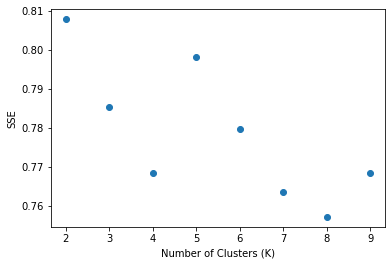

In [16]:
cluster_number = range(2,10)
plt.scatter(cluster_number,errors)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('SSE')
plt.show()

# Bước 4: Chọn cụm lại và huấn luyện lại

* Chọn số cụm k = 3
* Huấn luyện lại

In [17]:
# lựa chọn cụm k =3
kmeans = KMeans(featuresCol='features',k=3,)

# huấn luyện lại mô hình
model = kmeans.fit(dataset)

# Sau khi huấn luyện ta có thêm cột 'prediction' với dữ liệu 'dataset'

# Hiển thị dữ liệu dự báo và đếm qua hàm count()
model.transform(dataset).groupBy('prediction').count().show()

# Tính các giá trị 'predictions' cho dữ liệu 
predictions=model.transform(dataset)

# xem thông tin trên cột predictions
predictions.columns

# Nhóm dữ liệu dự báo 'predictions' theo trường 'rating' và 'prediction'
predictions.groupBy('rating','prediction').count().show()

# Chuyển dữ liệu 'predictions' sang dạng bảng DataFrame
df_DataFrame = predictions.toPandas()

# Xem 5 mẫu trên bảng dữ liệu
df_DataFrame.sample(5)

+----------+-----+
|prediction|count|
+----------+-----+
|         1|27778|
|         2|32998|
|         0|39228|
+----------+-----+

+------+----------+-----+
|rating|prediction|count|
+------+----------+-----+
|   3.5|         2| 5959|
|   2.0|         1| 1696|
|   4.5|         1| 3517|
|   1.0|         0| 1880|
|   1.0|         2|  833|
|   3.5|         1| 4579|
|   2.0|         2| 1882|
|   4.5|         2| 4206|
|   2.0|         0| 3693|
|   1.5|         1|  868|
|   4.0|         0|13806|
|   4.0|         1| 6606|
|   1.5|         2|  819|
|   5.0|         0| 8671|
|   3.0|         1| 3795|
|   3.0|         2| 5091|
|   2.5|         1| 2138|
|   5.0|         2| 2971|
|   1.0|         1|  613|
|   4.0|         2| 8338|
+------+----------+-----+
only showing top 20 rows



,userId,movieId,rating,timestamp,features,prediction
24813,178,3210,3.0,1437428385,"[178.0, 3210.0, 3.0, 1437428385.0]",1
64906,463,1047,3.0,1051643302,"[463.0, 1047.0, 3.0, 1051643302.0]",2
48398,355,47,5.0,1130104016,"[355.0, 47.0, 5.0, 1130104016.0]",2
99855,669,3826,2.0,1015829486,"[669.0, 3826.0, 2.0, 1015829486.0]",0
4926,26,58559,5.0,1352597791,"[26.0, 58559.0, 5.0, 1352597791.0]",1


# Bước 5: Biểu diễn dữ liệu trong không gian 3 chiều

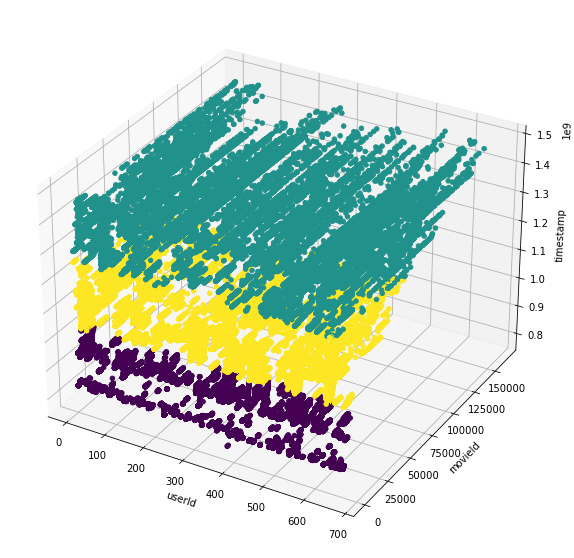

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Tạo biểu đồ 3D cho các điểm dữ liệu sử dụng 3 giá trị: userId, movieId, timestamp
# c là số màu (ở đây c = 3)
cluster_vis = plt.figure(figsize=(15,10)).add_subplot(111, projection='3d')
cluster_vis.scatter(df_DataFrame.userId, df_DataFrame.movieId, df_DataFrame.timestamp, c=df_DataFrame.prediction, depthshade=False)

# Thiết lập nhãn trục x, y,z
cluster_vis.set_xlabel('userId')
cluster_vis.set_ylabel('movieId')
cluster_vis.set_zlabel('timestamp')

# Vẽ đồ thị
plt.show()